<a href="https://colab.research.google.com/github/momanyid/machine-learning-as-beginner/blob/main/ddos_attack_prediction_using_cicddos_2019_refined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and treating CIC-DDoS-2019

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn import preprocessing

## Defining functions to load files and downsample them

As this research aims to develop a binary detector (Attack or Normal), we should balance the dataset between these two classes. However, CIC-DDOS2019 has few normal flows in it. Thus, downsampling is necessary.

For the downsampling process, we allow anomalous flows to be "mult" times bigger than normal flows. This approach aims to reduce class disbalance while preventing information losses on attack flows (when the number of attack flows is downsampled to the number of normal ones, ML models could not fit appropriately).  

In [ ]:
import pandas as pd
import random
from sklearn.utils import resample

mult = 5
num_samples = 5000  # Variable to control the number of rows to read

def load_file(path):
    # Count total lines in the file (excluding header)
    total_lines = sum(1 for _ in open(path)) - 1

    # Ensure at most `num_samples` rows are read randomly
    if total_lines > num_samples:
        skip_rows = sorted(random.sample(range(1, total_lines + 1), total_lines - num_samples))
    else:
        skip_rows = None  # Read entire file if it's smaller than `num_samples`

    data = pd.read_csv(path, skiprows=skip_rows, sep=',', low_memory=False)

    is_benign = data[' Label'] == 'BENIGN'
    flows_ok = data[is_benign]
    flows_ddos_full = data[~is_benign]

    sizeDownSample = max(1, len(flows_ok) * mult)  # Ensure at least 1 sample
    # sizeDownSample = len(flows_ok) * mult  # Target size for anomalous data

    # Downsample majority class
    if sizeDownSample < len(flows_ddos_full):
        flows_ddos_reduced = resample(
            flows_ddos_full,
            replace=False,
            n_samples=sizeDownSample,
            random_state=27
        )
    else:
        flows_ddos_reduced = flows_ddos_full

    final_df = pd.concat([flows_ok, flows_ddos_reduced])

    return final_df


def load_huge_file(path):
    total_lines = sum(1 for _ in open(path)) - 1

    if total_lines > num_samples:
        skip_rows = sorted(random.sample(range(1, total_lines + 1), total_lines - num_samples))
    else:
        skip_rows = None

    df_chunk = pd.read_csv(path, skiprows=skip_rows, chunksize=500000, low_memory=False)

    chunk_list_ok = []
    chunk_list_ddos = []

    for chunk in df_chunk:
        is_benign = chunk[' Label'] == 'BENIGN'
        flows_ok = chunk[is_benign]
        flows_ddos_full = chunk[~is_benign]

        if (len(flows_ok) * mult) < len(flows_ddos_full):
            # sizeDownSample = len(flows_ok) * mult
            sizeDownSample = max(1, len(flows_ok) * mult)  # Ensure at least 1 sample

            flows_ddos_reduced = resample(
                flows_ddos_full,
                replace=False,
                n_samples=sizeDownSample,
                random_state=27
            )
        else:
            flows_ddos_reduced = flows_ddos_full

        chunk_list_ok.append(flows_ok)
        chunk_list_ddos.append(flows_ddos_reduced)

    flows_ok = pd.concat(chunk_list_ok)
    flows_ddos = pd.concat(chunk_list_ddos)

    final_df = pd.concat([flows_ok, flows_ddos])

    return final_df


COnnecting kaggle

Upload the kagle file downloaded from kagle api section


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

### Download datasets using kaggle api

In [ ]:
!kaggle datasets download -d rodrigorosasilva/cic-ddos2019-30gb-full-dataset-csv-files

Dataset URL: https://www.kaggle.com/datasets/rodrigorosasilva/cic-ddos2019-30gb-full-dataset-csv-files
License(s): other


## Unzip the datasets

In [ ]:
!unzip cic-ddos2019-30gb-full-dataset-csv-files.zip -d /content/

Archive:  cic-ddos2019-30gb-full-dataset-csv-files.zip
  inflating: /content/01-12/DrDoS_DNS.csv  
  inflating: /content/01-12/DrDoS_LDAP.csv  
  inflating: /content/01-12/DrDoS_MSSQL.csv  
  inflating: /content/01-12/DrDoS_NTP.csv  
  inflating: /content/01-12/DrDoS_NetBIOS.csv  
  inflating: /content/01-12/DrDoS_SNMP.csv  
  inflating: /content/01-12/DrDoS_SSDP.csv  
  inflating: /content/01-12/DrDoS_UDP.csv  
  inflating: /content/01-12/Syn.csv  
  inflating: /content/01-12/TFTP.csv  
  inflating: /content/01-12/UDPLag.csv  
  inflating: /content/03-11/LDAP.csv  
  inflating: /content/03-11/MSSQL.csv  
  inflating: /content/03-11/NetBIOS.csv  
  inflating: /content/03-11/Portmap.csv  
  inflating: /content/03-11/Syn.csv  
  inflating: /content/03-11/UDP.csv  
  inflating: /content/03-11/UDPLag.csv  


## Loading CIC-DDoS2019 - Day 1 (training)

In [ ]:
# Load first file
flows = load_huge_file('/content/01-12/TFTP.csv')
print('file 1 loaded')

# List of remaining files
files = [
    "DrDoS_LDAP.csv", "DrDoS_MSSQL.csv", "DrDoS_NetBIOS.csv",
    "DrDoS_NTP.csv", "DrDoS_SNMP.csv", "DrDoS_SSDP.csv",
    "DrDoS_UDP.csv", "Syn.csv", "DrDoS_DNS.csv", "UDPLag.csv"
]

# Process each file
for i, file in enumerate(files, start=2):
    df = load_file(f'01-12/{file}')

    # Concatenate new file data
    flows = pd.concat([flows, df], ignore_index=True)

    print(f'file {i} loaded {file}')

# Save to CSV
flows.to_csv('/content/export_dataframe.csv', index=False, header=True)

# Delete large variable
del flows


file 1 loaded
file 2 loaded DrDoS_LDAP.csv
file 3 loaded DrDoS_MSSQL.csv
file 4 loaded DrDoS_NetBIOS.csv
file 5 loaded DrDoS_NTP.csv
file 6 loaded DrDoS_SNMP.csv
file 7 loaded DrDoS_SSDP.csv
file 8 loaded DrDoS_UDP.csv
file 9 loaded Syn.csv
file 10 loaded DrDoS_DNS.csv
file 11 loaded UDPLag.csv


## Loading CIC-DDoS2019 - Day 2 (testing)

In [ ]:
import pandas as pd

# File paths
base_path = "/content/03-11/"
files = ["LDAP.csv", "MSSQL.csv", "NetBIOS.csv", "Portmap.csv", "Syn.csv"]
# Uncomment if fixed
# files += ["UDP.csv", "UDPLag.csv"]

# Load first file
flows = load_file(base_path + files[0])  # Expecting ONE DataFrame
print('file 1 loaded')

# Load remaining files
for i, file in enumerate(files[1:], start=2):
    df = load_file(base_path + file)  # Expecting ONE DataFrame

    # Concatenate the new file data
    flows = pd.concat([flows, df], ignore_index=True)

    print(f'file {i} loaded {file}')

# Save to CSV
flows.to_csv('/content/export_tests.csv', index=False, header=True)

# Free memory
del flows, df


file 1 loaded
file 2 loaded MSSQL.csv
file 3 loaded NetBIOS.csv
file 4 loaded Portmap.csv
file 5 loaded Syn.csv


## CIC-DDoS2019 Data Processing

In [ ]:
import pandas as pd
import numpy as np
import hashlib

# Load dataset
samples = pd.read_csv('/content/export_dataframe.csv', sep=',')

# Function to convert string to numeric hash
def string2numeric_hash(text):
    return int(hashlib.md5(text.encode()).hexdigest()[:8], 16)

# Replace infinite values
samples = samples.replace(['Infinity', np.inf], 0)

# Convert numerical columns safely
samples[' Flow Packets/s'] = pd.to_numeric(samples[' Flow Packets/s'], errors='coerce').fillna(0)
samples['Flow Bytes/s'] = pd.to_numeric(samples['Flow Bytes/s'], errors='coerce').fillna(0)

# Convert labels to numeric
samples[' Label'] = samples[' Label'].replace({
    'BENIGN': 0, 'DrDoS_DNS': 1, 'DrDoS_LDAP': 1, 'DrDoS_MSSQL': 1,
    'DrDoS_NTP': 1, 'DrDoS_NetBIOS': 1, 'DrDoS_SNMP': 1, 'DrDoS_SSDP': 1,
    'DrDoS_UDP': 1, 'Syn': 1, 'TFTP': 1, 'UDP-lag': 1, 'WebDDoS': 1
}).astype(int)

# Ensure no NaN timestamps before splitting
samples[' Timestamp'] = samples[' Timestamp'].fillna('1970-01-01 00:00:00.000000')

# Process timestamps
colunaTime = samples[' Timestamp'].str.split(' ', n=1, expand=True)
colunaTime.columns = ['dia', 'horas']
colunaTime = colunaTime['horas'].str.split('.', n=1, expand=True)
colunaTime.columns = ['horas', 'milisec']
samples[' Timestamp'] = colunaTime['horas'].apply(string2numeric_hash)

# Drop unnecessary columns
samples.drop(columns=[' Source IP', ' Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0'], inplace=True)

# Save processed dataset
samples.to_csv('/content/export_dataframe_proc.csv', index=False, header=True)

print('Training data processed successfully!')


Training data processed successfully!


<ipython-input-14-8e3346d7f06d>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  samples[' Label'] = samples[' Label'].replace({


In [ ]:
import pandas as pd
import numpy as np
import hashlib

# Load dataset
tests = pd.read_csv('/content/export_tests.csv', sep=',')

# Function to convert string to numeric hash
def string2numeric_hash(text):
    return int(hashlib.md5(text.encode()).hexdigest()[:8], 16)

# Replace infinite values
tests = tests.replace(['Infinity', np.inf], 0)

# Convert numerical columns safely
tests[' Flow Packets/s'] = pd.to_numeric(tests[' Flow Packets/s'], errors='coerce').fillna(0)
tests['Flow Bytes/s'] = pd.to_numeric(tests['Flow Bytes/s'], errors='coerce').fillna(0)

# Convert labels to numeric
tests[' Label'] = tests[' Label'].replace({
    'BENIGN': 0, 'LDAP': 1, 'NetBIOS': 1, 'MSSQL': 1,
    'Portmap': 1, 'Syn': 1
}).astype(int)

# Ensure no NaN timestamps before splitting
tests[' Timestamp'] = tests[' Timestamp'].fillna('1970-01-01 00:00:00.000000')

# Process timestamps
colunaTime = tests[' Timestamp'].str.split(' ', n=1, expand=True)
colunaTime.columns = ['dia', 'horas']
colunaTime = colunaTime['horas'].str.split('.', n=1, expand=True)
colunaTime.columns = ['horas', 'milisec']
tests[' Timestamp'] = colunaTime['horas'].apply(string2numeric_hash)

# Drop unnecessary columns
tests.drop(columns=[' Source IP', ' Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0'], inplace=True)

# Save processed dataset
tests.to_csv('/content/export_tests_proc.csv', index=False, header=True)

print('Test data processed successfully!')


Test data processed successfully!


<ipython-input-15-55af07190a15>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tests[' Label'] = tests[' Label'].replace({


## Methods implementation

Importing required library

In [ ]:
# Import required libraries
from keras.models import Sequential

from keras.layers import Dense,GRU,Embedding,Dropout,Flatten,Conv1D,MaxPooling1D,LSTM
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

### Gated Recurrent Units (GRU)

In [ ]:
#input_size
# -> CIC-DDoS2019 82
# -> CIC-IDS2018 78

def GRU_model(input_size):

    # Initialize the constructor
    model = Sequential()

    model.add(GRU(32, input_shape=(input_size,1), return_sequences=False)) #
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.build()
    print(model.summary())

    return model

### Convolutional Neural Network (CNN)

In [ ]:
def CNN_model(input_size):

    # Initialize the constructor
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(input_size,1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=32, kernel_size=16, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))

    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    return model

### Long-Short Term Memory (LSTM)

In [ ]:
def LSTM_model(input_size):

    # Initialize the constructor
    model = Sequential()

    model.add(LSTM(32,input_shape=(input_size,1), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    return model

### Deep Neural Network (DNN)

In [ ]:
def DNN_model(input_size):

    # Initialize the constructor
    model = Sequential()

    model.add(Dense(2, activation='relu', input_shape=(input_size,)))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(40, activation='relu'))
    #model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    return model

### Support Vector Machine (SVM)

In [ ]:
def SVM():
    return SVC(kernel='linear')

### Logistic Regression (LR)

In [ ]:
def LR():
    return LogisticRegression()

### Gradient Descent (GD)

In [ ]:
def GD():
    return SGDClassifier()

### k Nearest Neighbors (kNN)

In [ ]:
def kNN():
    return KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Auxiliar Functions

Implementation of auxiliar functions, such as testing, compiling/training, 3d reshape, etc.

### train_test(samples)
> Receives a group of samples and split it in train/test sets.

In [ ]:
def train_test(samples):
    # Import `train_test_split` from `sklearn.model_selection`
    from sklearn.model_selection import train_test_split
    import numpy as np

    # Specify the data
    X=samples.iloc[:,0:(samples.shape[1]-1)]

    # Specify the target labels and flatten the array
    #y= np.ravel(amostras.type)
    y= samples.iloc[:,-1]

    # Split the data up in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, X_test, y_train, y_test


### normalize_data(X_train,X_test)

> Normalize data between -1 and 1

In [ ]:
# normalize input data

def normalize_data(X_train,X_test):
    # Import `StandardScaler` from `sklearn.preprocessing`
    from sklearn.preprocessing import StandardScaler,MinMaxScaler

    # Define the scaler
    #scaler = StandardScaler().fit(X_train)
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)

    # Scale the train set
    X_train = scaler.transform(X_train)

    # Scale the test set
    X_test = scaler.transform(X_test)

    return X_train, X_test


### format_{2,3}d()

> Reshape data in 3d or 2d format (for input in methods such as GRU, CNN and LSTM)

In [ ]:
# Reshape data input

def format_3d(df):

    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

def format_2d(df):

    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1]))

### compile_train(model,X_train,y_train,deep=True)

> Compile and train learning model

> deep = False for scikit-learn ML methods


In [ ]:
# compile and train learning model
def compile_train(model, X_train, y_train, deep=True):

    if(deep==True):
        import matplotlib.pyplot as plt

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        history = model.fit(X_train, y_train, epochs=10, batch_size=256, verbose=1)

        # summarize history for accuracy
        plt.plot(history.history['accuracy'])  # Corrected key from 'acc' to 'accuracy'
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper left')
        plt.show()

        print(model.metrics_names)

    else:
        model.fit(X_train, y_train)  # For SVM, LR, GD

    print('Model Compiled and Trained')
    return model


### testes(model,X_test,y_test,y_pred, deep=True)

> Testing performance outcomes of the methods

> deep = False for scikit-learn ML methods


In [ ]:
# Testing performance outcomes of the methods

def testes(model,X_test,y_test,y_pred, deep=True):
    if(deep==True):
        score = model.evaluate(X_test, y_test,verbose=1)

        print(score)

    # Alguns testes adicionais
    #y_test = formatar2d(y_test)
    #y_pred = formatar2d(y_pred)


    # Import the modules from `sklearn.metrics`
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print('\nAccuracy')
    print(acc)

    # Precision
    prec = precision_score(y_test, y_pred)#,average='macro')
    print('\nPrecision')
    print(prec)

    # Recall
    rec = recall_score(y_test, y_pred) #,average='macro')
    print('\nRecall')
    print(rec)

    # F1 score
    f1 = f1_score(y_test,y_pred) #,average='macro')
    print('\nF1 Score')
    print(f1)

    #average
    avrg = (acc+prec+rec+f1)/4
    print('\nAverage (acc, prec, rec, f1)')
    print(avrg)

    return acc, prec, rec, f1, avrg

### test_normal_atk(y_test,y_pred):

> Calculate the correct classification rate of normal and attack flow records

In [ ]:
def test_normal_atk(y_test,y_pred):
    df = pd.DataFrame()
    df['y_test'] = y_test
    df['y_pred'] = y_pred

    normal = len(df.query('y_test == 0'))
    atk = len(y_test)-normal

    wrong = df.query('y_test != y_pred')

    normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
    atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk

    #print(normal_detect_rate,atk_detect_rate)

    return normal_detect_rate, atk_detect_rate


**The replenished norma test atk function**

In [ ]:
def test_normal_atk(y_test, y_pred):
    df = pd.DataFrame()
    df['y_test'] = y_test
    df['y_pred'] = y_pred

    normal = len(df.query('y_test == 0'))
    atk = len(y_test) - normal

    wrong = df.query('y_test != y_pred')

    # Group by y_test and get the count
    wrong_counts = wrong.groupby('y_test').size().reset_index(name='count')

    # Calculate normal detection rate
    if normal > 0:
        # Check if there are any misclassified normal examples
        normal_wrong = wrong_counts[wrong_counts['y_test'] == 0]['count'].sum() if 0 in wrong_counts['y_test'].values else 0
        normal_detect_rate = (normal - normal_wrong) / normal
    else:
        normal_detect_rate = 0

    # Calculate attack detection rate
    if atk > 0:
        # Check if there are any misclassified attack examples
        atk_wrong = wrong_counts[wrong_counts['y_test'] == 1]['count'].sum() if 1 in wrong_counts['y_test'].values else 0
        atk_detect_rate = (atk - atk_wrong) / atk
    else:
        atk_detect_rate = 0

    return normal_detect_rate, atk_detect_rate

### Saving and Loading methods

> Methods for saving and loading trained models

In [ ]:
# Save model and weights

def save_model(model,name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    model_json = model.to_json()
    with open(arq_json,"w") as json_file:
        json_file.write(model_json)

    arq_h5 = 'Models/' + name + '.h5'
    model.save_weights(arq_h5)
    print('Model Saved')

def load_model(name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    json_file = open(arq_json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    arq_h5 = 'Models/' + name + '.h5'
    loaded_model.load_weights(arq_h5)

    print('Model loaded')

    return loaded_model

def save_Sklearn(model,nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'wb') as file:
        pickle.dump(model,file)
    print('Model sklearn saved')

def load_Sklearn(nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'rb') as file:
        model = pickle.load(file)
    print('Model sklearn loaded')
    return model

# Main script for testing the learning methods

> **Dataset - CIC-DDoS2019**

Loading training dataset, upsampling normal flows for balancing the training set.

In [ ]:
# UPSAMPLE OF NORMAL FLOWS

samples = pd.read_csv('/content/export_dataframe_proc.csv', sep=',')

X_train, X_test, y_train, y_test = train_test(samples)


#junta novamente pra aumentar o numero de normais
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
is_benign = X[' Label']==0 #base de dados toda junta

normal = X[is_benign]
ddos = X[~is_benign]

# upsample minority
normal_upsampled = resample(normal,
                          replace=True, # sample with replacement
                          n_samples=len(ddos), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([normal_upsampled, ddos])

# Specify the data
X_train=upsampled.iloc[:,0:(upsampled.shape[1]-1)]    #DDoS
y_train= upsampled.iloc[:,-1]  #DDoS

input_size = (X_train.shape[1], 1)

del X, normal_upsampled, ddos, upsampled, normal #, l1, l2

Importing the test dataset (day 2) and normalizing data.

In [ ]:
tests = pd.read_csv('/content/export_tests_proc.csv', sep=',')

# X_test = np.concatenate((X_test,(tests.iloc[:,0:(tests.shape[1]-1)]).to_numpy())) # testar 33% + dia de testes
# y_test = np.concatenate((y_test,tests.iloc[:,-1]))

del X_test,y_test                            # testar só o dia de testes
X_test = tests.iloc[:,0:(tests.shape[1]-1)]
y_test = tests.iloc[:,-1]

print((y_test.shape))
print((X_test.shape))

X_train, X_test = normalize_data(X_train,X_test)


(1152,)
(1152, 82)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Compiling and Training the methods

> Comment the last 2 code blocks

**OR**

Loading and compiling the methods

> Comment the first 2 code blocks

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 32)                  │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,701 (14.46 KB)

 Trainable params: 3,701 (14.46 KB)

 Non-trainable params: 0 (0.00 B)

None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 75, 64)              │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 37, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 22, 32)              │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 11, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 9, 16)               │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 4, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,589 (139.02 KB)

 Trainable params: 35,589 (139.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,693 (18.33 KB)

 Trainable params: 4,693 (18.33 KB)

 Non-trainable params: 0 (0.00 B)

None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 2)                   │             166 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6565 - loss: 0.6911
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7678 - loss: 0.6708
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8407 - loss: 0.6531
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8950 - loss: 0.6319
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8954 - loss: 0.6143
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9013 - loss: 0.5992
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9090 - loss: 0.5811
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9110 - loss: 0.5652
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9253 - loss: 0.5486
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9227 - loss: 0.5359


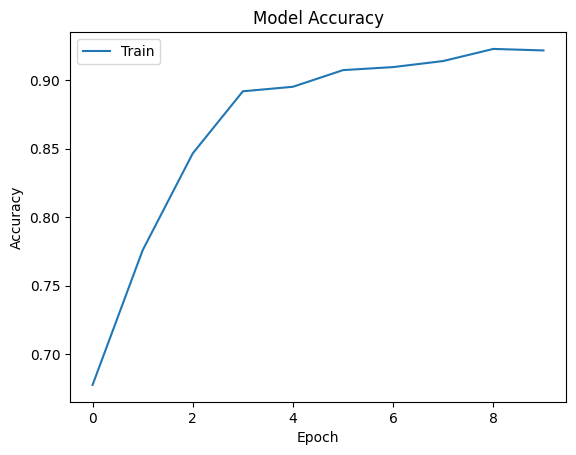

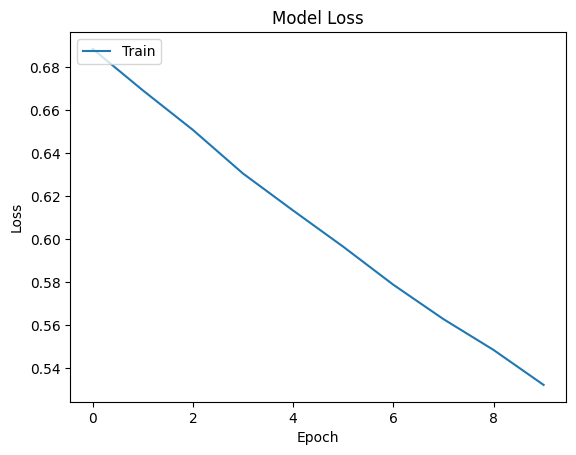

['loss', 'compile_metrics']
Model Compiled and Trained
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5761 - loss: 0.6855
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7028 - loss: 0.6528
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7370 - loss: 0.6217
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7806 - loss: 0.5729
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8336 - loss: 0.5267
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8412 - loss: 0.4671
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8585 - loss: 0.4423
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9218 - loss: 0.3718
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9277 - loss: 0.3149
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9392 - loss: 0.2600


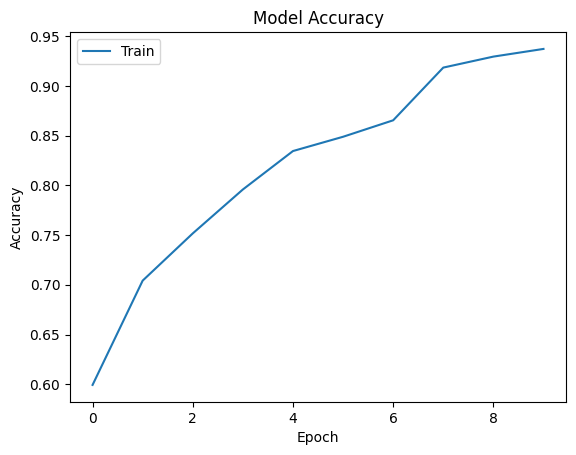

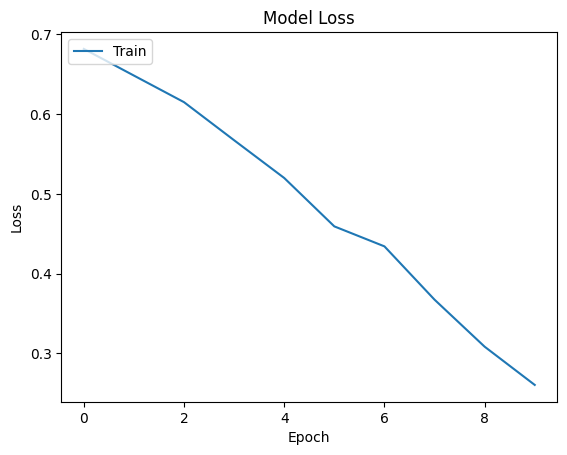

['loss', 'compile_metrics']
Model Compiled and Trained
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.5327 - loss: 0.6965
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5957 - loss: 0.6871
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6258 - loss: 0.6806
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6777 - loss: 0.6721
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7038 - loss: 0.6670
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7173 - loss: 0.6604
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7783 - loss: 0.6490
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7457 - loss: 0.6420
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7523 - loss: 0.6324
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7574 - loss: 0.6223


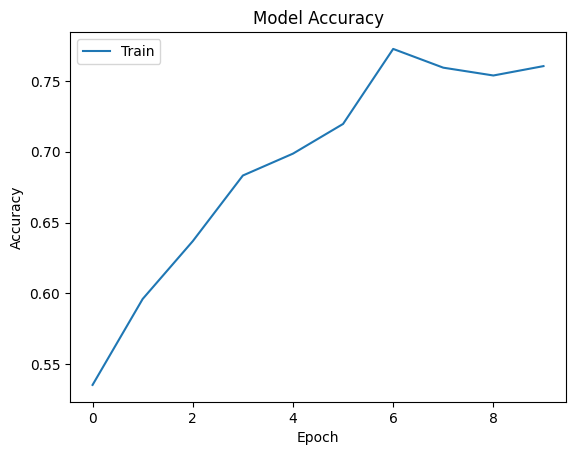

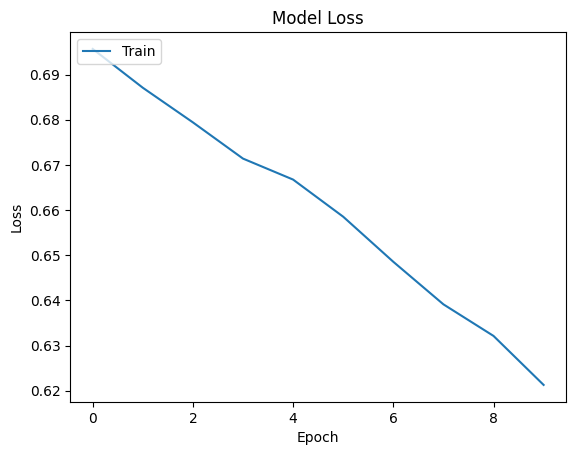

['loss', 'compile_metrics']
Model Compiled and Trained
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5273 - loss: 0.6976
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6002 - loss: 0.6924
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6121 - loss: 0.6899
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6169 - loss: 0.6862
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6089 - loss: 0.6846
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6400 - loss: 0.6812 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6610 - loss: 0.6787
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6519 - loss: 0.6761
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6787 - loss: 0.6735
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6922 - loss: 0.6691


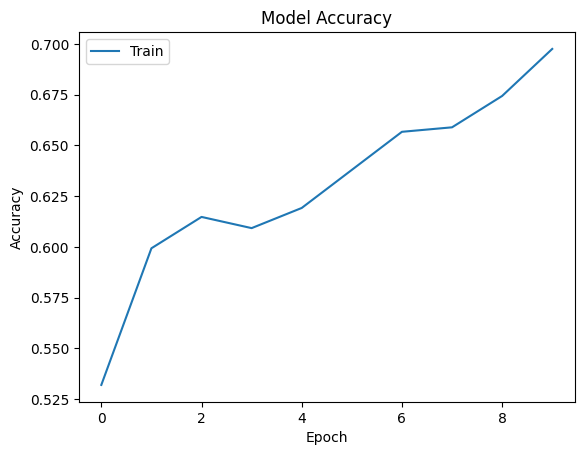

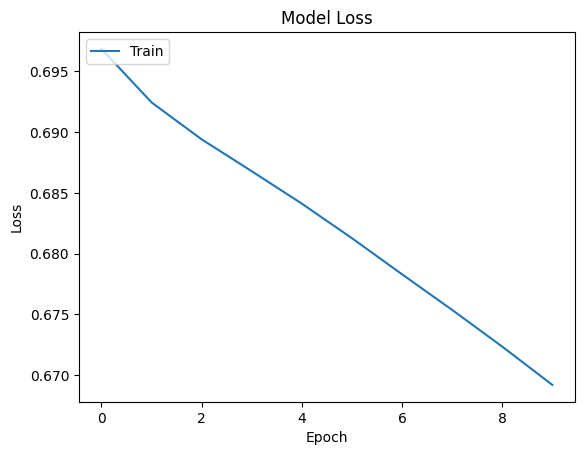

['loss', 'compile_metrics']
Model Compiled and Trained
Model Compiled and Trained
Model Compiled and Trained
Model Compiled and Trained
Model Compiled and Trained


In [ ]:

## Comment next 2 blocks if loading pre-trained models
## Execute them if training new models

model_gru = GRU_model(X_train.shape[1]) #quando treina novo modelo
model_cnn = CNN_model(X_train.shape[1])
model_lstm = LSTM_model(X_train.shape[1])
model_dnn = DNN_model(X_train.shape[1])
model_svm = SVM()
model_lr = LR()
model_gd = GD()
model_knn = kNN()

model_gru = compile_train(model_gru,format_3d(X_train),y_train)  #quando treina novo modelo, ou retreina
model_cnn = compile_train(model_cnn,format_3d(X_train),y_train)
model_lstm = compile_train(model_lstm,format_3d(X_train),y_train)
model_dnn = compile_train(model_dnn,X_train,y_train)
model_svm = compile_train(model_svm,X_train,y_train,False)
model_lr = compile_train(model_lr,X_train,y_train,False)
model_gd = compile_train(model_gd,X_train,y_train,False)
model_knn = compile_train(model_knn,X_train,y_train,False)

## Comment next 2 blocks if training new models
## Execute them if loading pre-trained models

# model_gru = load_model('GRU20-32-b256') #when loading previously saved trained model and weights
# model_cnn = load_model('CNN5-3cam-b2560')
# model_lstm = load_model('LSTM5-32-b256')
# model_dnn = load_model('DNN5-2560')
# model_svm = load_Sklearn('SVM')
# model_lr = load_Sklearn('LR')
# model_gd = load_Sklearn('GD')
# model_knn = load_Sklearn('kNN-1viz')

# model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #qdo carrega modelo salvo
# model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Testing CIC-DDoS2019

In [ ]:
results = pd.DataFrame(columns=['Method','Accuracy','Precision','Recall', 'F1_Score', 'Average','Normal_Detect_Rate','Atk_Detect_Rate'])

### GRU

In [ ]:
y_pred = model_gru.predict(format_3d(X_test))

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_gru,format_3d(X_test),y_test,y_pred)

norm, atk = test_normal_atk(y_test,y_pred)

# Replace append with concat
results = pd.concat([results, pd.DataFrame([{'Method': 'GRU', 'Accuracy': acc, 'Precision': prec,
                                             'F1_Score': f1, 'Recall': rec, 'Average': avrg,
                                             'Normal_Detect_Rate': norm, 'Atk_Detect_Rate': atk}])],
                     ignore_index=True)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7138 - loss: 0.5943
[0.5493913888931274, 0.8333333134651184]

Accuracy
0.8333333333333334

Precision
0.8333333333333334

Recall
1.0

F1 Score
0.9090909090909091

Average (acc, prec, rec, f1)
0.893939393939394


### CNN

In [ ]:
y_pred = model_cnn.predict(format_3d(X_test))

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_cnn, format_3d(X_test), y_test, y_pred)

norm, atk = test_normal_atk(y_test, y_pred)

# Replace append with concat
results = pd.concat([results, pd.DataFrame([{'Method': 'CNN', 'Accuracy': acc, 'Precision': prec,
                                             'F1_Score': f1, 'Recall': rec, 'Average': avrg,
                                             'Normal_Detect_Rate': norm, 'Atk_Detect_Rate': atk}])],
                     ignore_index=True)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7199 - loss: 13067748.0000
[9223192.0, 0.8350694179534912]

Accuracy
0.8350694444444444

Precision
0.8431372549019608

Recall
0.9854166666666667

F1 Score
0.9087415946205571

Average (acc, prec, rec, f1)
0.8930912401584072


### LSTM

In [ ]:
y_pred = model_lstm.predict(format_3d(X_test))

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_lstm, format_3d(X_test), y_test, y_pred)

norm, atk = test_normal_atk(y_test, y_pred)

# Replace append with concat
results = pd.concat([results, pd.DataFrame([{'Method': 'LSTM', 'Accuracy': acc, 'Precision': prec,
                                             'F1_Score': f1, 'Recall': rec, 'Average': avrg,
                                             'Normal_Detect_Rate': norm, 'Atk_Detect_Rate': atk}])],
                     ignore_index=True)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7138 - loss: 0.6951
[0.6888779997825623, 0.8333333134651184]

Accuracy
0.8333333333333334

Precision
0.8333333333333334

Recall
1.0

F1 Score
0.9090909090909091

Average (acc, prec, rec, f1)
0.893939393939394


### DNN

In [ ]:
y_pred = model_dnn.predict(X_test)

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_dnn, X_test, y_test, y_pred)

norm, atk = test_normal_atk(y_test, y_pred)

# Replace append with concat
results = pd.concat([results, pd.DataFrame([{'Method': 'DNN', 'Accuracy': acc, 'Precision': prec,
                                             'F1_Score': f1, 'Recall': rec, 'Average': avrg,
                                             'Normal_Detect_Rate': norm, 'Atk_Detect_Rate': atk}])],
                     ignore_index=True)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6158 - loss: 1932759.8750
[980483.4375, 0.7864583134651184]

Accuracy
0.7864583333333334

Precision
0.8269230769230769

Recall
0.940625

F1 Score
0.8801169590643275

Average (acc, prec, rec, f1)
0.8585308423301845


### SVM

In [ ]:
y_pred = model_svm.predict(X_test)

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_svm, X_test, y_test, y_pred, False)

norm, atk = test_normal_atk(y_test, y_pred)

# Replace append with concat
results = pd.concat([results, pd.DataFrame([{'Method': 'SVM', 'Accuracy': acc, 'Precision': prec,
                                             'F1_Score': f1, 'Recall': rec, 'Average': avrg,
                                             'Normal_Detect_Rate': norm, 'Atk_Detect_Rate': atk}])],
                     ignore_index=True)



Accuracy
0.8359375

Precision
0.8360941586748039

Recall
0.9989583333333333

F1 Score
0.9102990033222591

Average (acc, prec, rec, f1)
0.895322248832599


### LR

In [ ]:
y_pred = model_lr.predict(X_test)

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_lr, X_test, y_test, y_pred, False)

norm, atk = test_normal_atk(y_test, y_pred)

# Replace append with concat
results = pd.concat([results, pd.DataFrame([{'Method': 'LR', 'Accuracy': acc, 'Precision': prec,
                                             'F1_Score': f1, 'Recall': rec, 'Average': avrg,
                                             'Normal_Detect_Rate': norm, 'Atk_Detect_Rate': atk}])],
                     ignore_index=True)



Accuracy
0.8350694444444444

Precision
0.8347826086956521

Recall
1.0

F1 Score
0.909952606635071

Average (acc, prec, rec, f1)
0.8949511649437919


### GB

In [ ]:
y_pred = model_gd.predict(X_test)

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_gd, X_test, y_test, y_pred, False)

norm, atk = test_normal_atk(y_test, y_pred)

# Replace append with concat
results = pd.concat([results, pd.DataFrame([{'Method': 'GB', 'Accuracy': acc, 'Precision': prec,
                                             'F1_Score': f1, 'Recall': rec, 'Average': avrg,
                                             'Normal_Detect_Rate': norm, 'Atk_Detect_Rate': atk}])],
                     ignore_index=True)



Accuracy
0.8333333333333334

Precision
0.8333333333333334

Recall
1.0

F1 Score
0.9090909090909091

Average (acc, prec, rec, f1)
0.893939393939394


### kNN

In [ ]:
y_pred = model_knn.predict(X_test)

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_knn, X_test, y_test, y_pred, False)

norm, atk = test_normal_atk(y_test, y_pred)

# Replace append with concat
results = pd.concat([results, pd.DataFrame([{'Method': 'kNN', 'Accuracy': acc, 'Precision': prec,
                                             'F1_Score': f1, 'Recall': rec, 'Average': avrg,
                                             'Normal_Detect_Rate': norm, 'Atk_Detect_Rate': atk}])],
                     ignore_index=True)



Accuracy
0.8576388888888888

Precision
0.8658088235294118

Recall
0.98125

F1 Score
0.919921875

Average (acc, prec, rec, f1)
0.9061548968545752


# Discussion and Results

Showing the table 'results', containing the performance metrics outcomes for each method.

In [ ]:
results

,Method,Accuracy,Precision,Recall,F1_Score,Average,Normal_Detect_Rate,Atk_Detect_Rate
0,GRU,0.833333,0.833333,1.000000,0.909091,0.893939,0.000000,1.000000
1,CNN,0.835069,0.843137,0.985417,0.908742,0.893091,0.083333,0.985417
2,LSTM,0.833333,0.833333,1.000000,0.909091,0.893939,0.000000,1.000000
3,DNN,0.786458,0.826923,0.940625,0.880117,0.858531,0.015625,0.940625
4,SVM,0.835938,0.836094,0.998958,0.910299,0.895322,0.020833,0.998958
5,LR,0.835069,0.834783,1.000000,0.909953,0.894951,0.010417,1.000000
6,GB,0.833333,0.833333,1.000000,0.909091,0.893939,0.000000,1.000000
7,kNN,0.857639,0.865809,0.981250,0.919922,0.906155,0.239583,0.981250


**Classification Metrics:**
* Accuracy
* Precision
* Recall
* F1 Measure (F1 Score)

Showing performance outcomes of the methods:
* GRU
* DNN
* SVM
* LR
* GB
* kNN

LSTM and CNN were separated for visualization improvement.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
ax = sns.catplot(data=results.iloc[:,:5].query('Method != "LSTM" and Method != "CNN"'), col='Method', col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.99,1))
ax.set_xticklabels(rotation=45)
ax = ax


ValueError: The following variable cannot be assigned with wide-form data: `col`

> As observed, the evaluated methods achieved good performance outcomes close to 1. As the evaluated methods achieved similar outcomes, a more specific analysis should be performed.

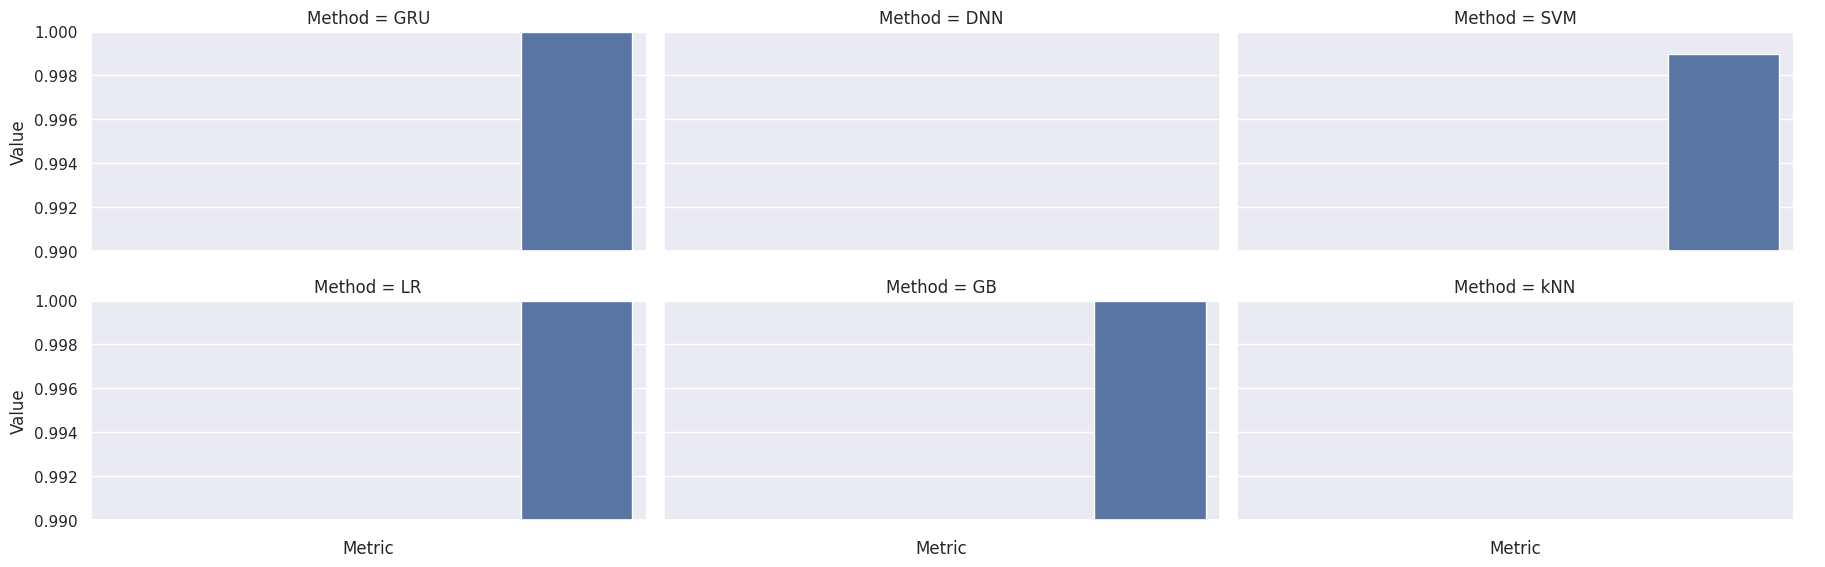

In [ ]:
# Filter the data
filtered_results = results.iloc[:,:5].query('Method != "LSTM" and Method != "CNN"')

# Reshape the data from wide to long format
melted_results = filtered_results.melt(id_vars=['Method'],
                                      value_vars=['Accuracy', 'Precision', 'F1_Score', 'Recall'],
                                      var_name='Metric', value_name='Value')

# Create the plot
ax = sns.catplot(data=melted_results, x='Metric', y='Value', col='Method',
                col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.99, 1))
ax.set_xticklabels(rotation=45)

Showing results of the LSTM and CNN methods.

In [ ]:
ax = sns.catplot(data=results.iloc[:,:5].query('Method == "LSTM" or Method == "CNN"'), col='Method', col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.97,1))
ax.set_xticklabels(rotation=45)
ax = ax

ValueError: The following variable cannot be assigned with wide-form data: `col`

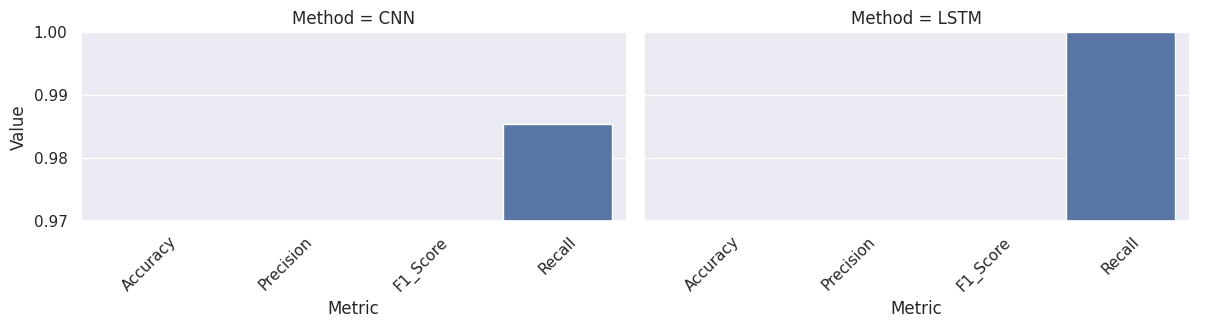

In [ ]:
# Filter the data for LSTM and CNN methods
filtered_results = results.iloc[:,:5].query('Method == "LSTM" or Method == "CNN"')

# Reshape the data from wide to long format
melted_results = filtered_results.melt(id_vars=['Method'],
                                     value_vars=['Accuracy', 'Precision', 'F1_Score', 'Recall'],
                                     var_name='Metric', value_name='Value')

# Create the plot
ax = sns.catplot(data=melted_results, x='Metric', y='Value', col='Method',
                col_wrap=2, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.97, 1))
ax.set_xticklabels(rotation=45)

> CNN and LSTM fared worse between the tested approaches. However, these methods achieved performance metrics above 97%, which is a relatively good outcome.

**Average of the Metrics**

Plotting the Average of the previously mentioned performance metrics to summarize the method's results.

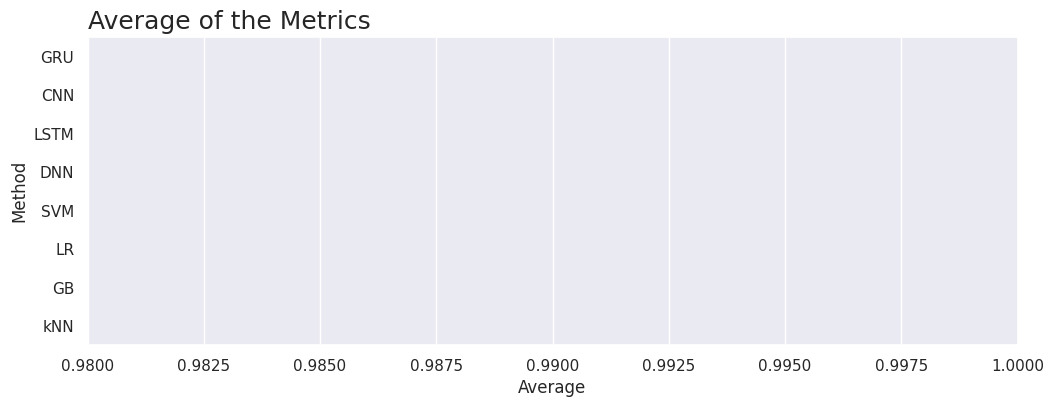

In [ ]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(data=results, y='Method', x='Average')
ax.set(xlim=(0.98, 1))
ax.set_title('Average of the Metrics', fontsize=18, loc='left')
# If you want to modify the x-tick labels, uncomment the line below and provide the desired labels
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Example for rotating labels
ax = ax
plt.show()


> As observed, on average, kNN fared slightly better compared to GB, LR, SVM, and GRU, which, in turn, achieved very similar results. However, these methods performed nearly 99.9%, which is considered a good classification outcome.

**Detection rate of Normal and Attack flow records**

The following plot shows the results of each method for classifying normal and attack flow records.

In [ ]:
ax = sns.catplot(data=results[['Method', 'Normal_Detect_Rate', 'Atk_Detect_Rate']], col='Method', col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.97,1))
ax.set_xticklabels(rotation=45)
ax = ax


ValueError: The following variable cannot be assigned with wide-form data: `col`

> kNN achieved the best classification outcomes.

> GRU showed the most balanced approach regarding classifying normal and attack flows.

> Although CNN achieved a relatively good classification of attacks, the classification of normal record flows was low compared to other methods. This result can explain the Accuracy rate of this method. This situation also occurs with the LSTM method, which achieved a good classification rate for normal flows and a low classification rate for attack ones.

In [ ]:
from tensorflow import keras

# Save the model
model.save('/content/my_model.keras')

# To download it
from google.colab import files
files.download('/content/my_model.keras')


NameError: name 'model' is not defined

## Save the models

In [ ]:
# Save Keras models
model_gru.save('gru_model.keras')
model_cnn.save('cnn_model.keras')
model_lstm.save('lstm_model.keras')
model_dnn.save('dnn_model.keras')


In [ ]:
from google.colab import files

files.download('gru_model.keras')
files.download('cnn_model.keras')
files.download('lstm_model.keras')
files.download('dnn_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

def save_Sklearn(model, filename):
    joblib.dump(model, f"{filename}.pkl")
    print(f"Model saved as {filename}.pkl")


In [ ]:
# Save Scikit-learn models

save_Sklearn(model_svm, 'svm_model')
save_Sklearn(model_lr, 'lr_model')
save_Sklearn(model_gd, 'gd_model')
save_Sklearn(model_knn, 'knn_model')

Model saved as svm_model.pkl
Model saved as lr_model.pkl
Model saved as gd_model.pkl
Model saved as knn_model.pkl


In [ ]:
files.download('svm_model.pkl')
files.download('lr_model.pkl')
files.download('gd_model.pkl')
files.download('knn_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>